# Bare soil sampling with Google Earth Engine

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from typing import List
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import glob
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))

### Create shp for querying with GEE

In [ ]:
tiles = {'32TMT': [(7.66286529045287, 47.845914826827),(7.68758850048273, 46.8581759574933),(9.12805716115049, 46.8656282472998),(9.1304703619161, 47.8536277114283),(7.66286529045287, 47.845914826827)],
            '32TLT': [(6.32792675947954,47.8225951267953),(6.37728036218156, 46.8356437136561),(7.81664846692137, 46.8595830833696),(7.79435498889756, 47.8473711518664),(6.32792675947954, 47.8225951267953)],
            '32TNT': [(8.9997326423426, 47.8537018420053),(8.99973758744939,46.8656998728757),(10.4401498244026, 46.8566398814282),(10.4672773767603, 47.8443250460311),(8.9997326423426, 47.8537018420053)],
            '32TNS': [(8.99973715756222,46.9537091787344),(8.9997418700468, 45.9655511480415),(10.4166561015996, 45.9567698586004),(10.442508097938, 46.9446214409232),(8.99973715756222, 46.9537091787344)],
            '32TMS': [(7.68543924709582, 46.9461622205863),(7.7089998702566, 45.9582586884214),(9.12596726307512, 45.9654817261501),(9.12826694512377, 46.9536373337673),(7.68543924709582, 46.9461622205863)],
            '32TLS': [(6.37298980762373, 46.9235610080068),(6.42002507864337, 45.9364192287437),(7.83595551698163, 45.9596225320207),(7.81471043979331, 46.94757365544),(6.37298980762373, 46.9235610080068)],
            '31TGM': [(5.62648535526562, 46.9235730577955),(5.57945945554239, 45.9364308725672),(6.99300216652316, 45.8957352511058),(7.06565713267192, 46.8814596607493),(5.62648535526562, 46.9235730577955)],
            '31TGN': [(5.67153942638492, 47.8226075594756),(5.62219565549863, 46.8356557266896),(7.05902986502132, 46.793670687313),(7.13525847525188, 47.7791570713891),(5.67153942638492, 47.8226075594756)]}

In [ ]:
geowp_path = '/home/f80873755@agsad.admin.ch/mnt/Data-Work-RE/27_Natural_Resources-RE/99_GIS_User_protected/GeoWP/Landuse/Landw_Kulturflaechen/2021/01_Geodata/SHP/Nutzungsflaechen_BLW_Schweizweit_merge/ln_nutzung_BLW_2021_CH.shp'
geowp = gpd.read_file(geowp_path).to_crs(4326)

In [ ]:
for tile_id, tile_coords in tiles.items():
    print(f'Creating shp for tile {tile_id}...')

    tile = Polygon(tile_coords)
    tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

    # Divide each tile into 4 smaller tiles
    subdivide_factor = 2  # You can adjust this based on requirement
    subdivided_tiles = []
    for i in range(subdivide_factor):
        for j in range(subdivide_factor):
            min_x, min_y, max_x, max_y = tile_gdf.total_bounds
            sub_tile = sg.box(
                min_x + i * (max_x - min_x) / subdivide_factor,
                min_y + j * (max_y - min_y) / subdivide_factor,
                min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
                min_y + (j + 1) * (max_y - min_y) / subdivide_factor
            )
            subdivided_tiles.append(sub_tile)

    # Save each subdivided tile
    for idx, sub_tile in enumerate(subdivided_tiles):
        print(sub_tile)
        # Take extra surrounding fields using GeoWP
        geowp_cropped = geowp.to_crs(4326).cx[sub_tile.bounds[0]:sub_tile.bounds[2], sub_tile.bounds[1]:sub_tile.bounds[3]]
        geowp_with_buffer = geowp_cropped.copy()
        buffer_distance = -60  # in meters, if the crs of the gdf is metric
        geowp_with_buffer['geometry'] = geowp_cropped.to_crs(2056).buffer(buffer_distance)
        sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')
        geom = gpd.overlay(sub_tile_gdf.to_crs(geowp_with_buffer.crs), geowp_with_buffer, how='intersection') # is in epsg 2056
        if len(geom):
            geom.to_crs(4326).to_file(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_{idx+1}.shp'))

In [ ]:
# Further divide a subtile

tile_id = '32TLT'
sub_tile_part = 3
    
tile_coords = tiles[tile_id]
tile = Polygon(tile_coords)
tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

# Get subtile
subdivide_factor = 2  # You can adjust this based on requirement
subdivided_tiles = []
for i in range(subdivide_factor):
    for j in range(subdivide_factor):
        min_x, min_y, max_x, max_y = tile_gdf.total_bounds
        sub_tile = sg.box(
            min_x + i * (max_x - min_x) / subdivide_factor,
            min_y + j * (max_y - min_y) / subdivide_factor,
            min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
            min_y + (j + 1) * (max_y - min_y) / subdivide_factor
        )
        subdivided_tiles.append(sub_tile)

sub_tile = subdivided_tiles[sub_tile_part-1]
sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')

# Split that  subtile
subdivide_factor = 2  # You can adjust this based on requirement
subdivided_tiles = []
for i in range(subdivide_factor):
    for j in range(subdivide_factor):
        min_x, min_y, max_x, max_y = sub_tile_gdf.total_bounds
        sub_tile_again = sg.box(
            min_x + i * (max_x - min_x) / subdivide_factor,
            min_y + j * (max_y - min_y) / subdivide_factor,
            min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
            min_y + (j + 1) * (max_y - min_y) / subdivide_factor
        )
        subdivided_tiles.append(sub_tile_again)

# Save each subdivided tile
for idx, sub_tile in enumerate(subdivided_tiles):
    # Take extra surrounding fields using GeoWP
    geowp_cropped = geowp.to_crs(4326).cx[sub_tile.bounds[0]:sub_tile.bounds[2], sub_tile.bounds[1]:sub_tile.bounds[3]]
    geowp_with_buffer = geowp_cropped.copy()
    buffer_distance = -60  # in meters, if the crs of the gdf is metric
    geowp_with_buffer['geometry'] = geowp_cropped.to_crs(2056).buffer(buffer_distance)
    sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')
    geom = gpd.overlay(sub_tile_gdf.to_crs(geowp_with_buffer.crs), geowp_with_buffer, how='intersection') # is in epsg 2056
    if len(geom):
        geom.to_crs(4326).to_file(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_{sub_tile_part}{idx+1}.shp'))

In [ ]:
# Plot the different subtiles

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))

#### The original tile
tile_id = '32TLT'
sub_tile_part = 3
    
tile_coords = tiles[tile_id]
tile = Polygon(tile_coords)
tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

tile_gdf.plot(ax=axs[0])
cx.add_basemap(axs[0], crs=tile_gdf.crs.to_string())
axs[0].set_title(tile_id)

#### The sub tile
# Get subtile
subdivide_factor = 2  # You can adjust this based on requirement
subdivided_tiles = []
for i in range(subdivide_factor):
    for j in range(subdivide_factor):
        min_x, min_y, max_x, max_y = tile_gdf.total_bounds
        sub_tile = sg.box(
            min_x + i * (max_x - min_x) / subdivide_factor,
            min_y + j * (max_y - min_y) / subdivide_factor,
            min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
            min_y + (j + 1) * (max_y - min_y) / subdivide_factor
        )
        subdivided_tiles.append(sub_tile)

sub_tile = subdivided_tiles[sub_tile_part-1]
sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')

sub_tile_gdf.plot(ax=axs[1])
bounds = tile_gdf.total_bounds
axs[1].set_xlim(bounds[0], bounds[2])
axs[1].set_ylim(bounds[1], bounds[3])
cx.add_basemap(axs[1], crs=tile_gdf.crs.to_string())
axs[1].set_title(f'{tile_id}-{sub_tile_part}')


#### The further split sub tile
# Split that  subtile
subdivide_factor = 2  # You can adjust this based on requirement
subdivided_tiles = []
for i in range(subdivide_factor):
    for j in range(subdivide_factor):
        min_x, min_y, max_x, max_y = sub_tile_gdf.total_bounds
        sub_tile_again = sg.box(
            min_x + i * (max_x - min_x) / subdivide_factor,
            min_y + j * (max_y - min_y) / subdivide_factor,
            min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
            min_y + (j + 1) * (max_y - min_y) / subdivide_factor
        )
        subdivided_tiles.append(sub_tile_again)

print(len(subdivided_tiles))
# Save each subdivided tile
for idx, sub_tile in enumerate(subdivided_tiles):
    sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')
    sub_tile_gdf.plot(ax=axs[idx+2])
    axs[idx+2].set_xlim(bounds[0], bounds[2])
    axs[idx+2].set_ylim(bounds[1], bounds[3])
    cx.add_basemap(axs[idx+2], crs=tile_gdf.crs.to_string())
    axs[idx+2].set_title(f'{tile_id}-{sub_tile_part}{idx+1}')

### View geom and subtiles

In [ ]:
# Open single subtile

tile_geowp = base_dir.joinpath('data/tile_geowp/32TNT_geowp_part_4.shp')
tile_geowp = gpd.read_file(tile_geowp)
print(len(tile_geowp))

In [ ]:
# Plot single subtile

tile_geowp = base_dir.joinpath('data/tile_geowp/32TMT_geowp_part_2.shp')
tile_geowp = gpd.read_file(tile_geowp)

fig, ax = plt.subplots(figsize=(8,6))
tile_geowp.plot(ax=ax, color='r')
cx.add_basemap(ax, crs=tile_geowp.crs)

In [ ]:
# Plot geom in subtiles

for row, (tile_id, _) in enumerate(tiles.items()):
    subtile_paths = glob.glob(str(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_*.shp')))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    for col, sub_tile in enumerate(subtile_paths):  # Assuming you want only the first 4 subtiles
        sub_tile_gdf = gpd.read_file(sub_tile)
        print(sub_tile, len(sub_tile_gdf))
        ax = axes[col] #axes[row, col]
        sub_tile_gdf.plot(ax=ax)
        ax.set_title(f'{tile_id} - {sub_tile.split("_")[-1].split(".")[0]}')
        cx.add_basemap(ax, crs=sub_tile_gdf.crs)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot subtile bounds

#fig, axes = plt.subplots(nrows=len(tiles), ncols=4, figsize=(15, len(tiles) * 4))

for row, (tile_id, tile_coords) in enumerate(tiles.items()):
    
    tile = Polygon(tile_coords)
    tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

    # Divide each tile into 4 smaller tiles
    subdivide_factor = 2  # You can adjust this based on requirement
    subdivided_tiles = []
    for i in range(subdivide_factor):
        for j in range(subdivide_factor):
            min_x, min_y, max_x, max_y = tile_gdf.total_bounds
            sub_tile = sg.box(
                min_x + i * (max_x - min_x) / subdivide_factor,
                min_y + j * (max_y - min_y) / subdivide_factor,
                min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
                min_y + (j + 1) * (max_y - min_y) / subdivide_factor
            )
            subdivided_tiles.append(sub_tile)


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    for idx, sub_tile in enumerate(subdivided_tiles):
        sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')

        ax = axes[idx]
        sub_tile_gdf.plot(ax=ax)
        ax.set_title(f'{tile_id} - part {idx+1}')
        bounds = tile_gdf.total_bounds
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])
        cx.add_basemap(ax, crs=sub_tile_gdf.crs)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

### Load rasters generated on GEE

In [ ]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np


def load_raster_gdf(tif_path: Path):
    """Load raster data into a GeoDataFrame.
    
    :param tif_path: Path to the GeoTIFF raster file
    """

    # Read the raster data using rasterio
    with rasterio.open(tif_path) as src:
        # Read raster data as a NumPy array
        raster_array = src.read()  # Read all bands

        # Get the metadata for coordinate reference system (CRS) and transform
        crs = src.crs.to_string()

    # Create a grid of points representing each pixel
    rows, cols = raster_array.shape[1:]
    x_coords, y_coords = np.meshgrid(np.linspace(src.bounds.left, src.bounds.right, cols),
                                    np.linspace(src.bounds.top, src.bounds.bottom, rows))

    # Flatten the coordinates
    flat_x_coords = x_coords.flatten()
    flat_y_coords = y_coords.flatten()

    # Create a GeoDataFrame with points
    geometry = [Point(x, y) for x, y in zip(flat_x_coords, flat_y_coords)]
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)

    # Add columns for each band value
    col_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'ndvi', 'nbr2']
    for i, band_values in enumerate(raster_array):
        gdf[f'{col_names[i]}'] = band_values.flatten()

    gdf.dropna(inplace=True)

    return gdf


# Specify the path to your GeoTIFF raster file
tif_path = base_dir.joinpath('data/S2_BS/S2_BS_2017_Strickhof.tif')
gdf = load_raster_gdf(tif_path)
gdf.head()

# Plot GEE data

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap

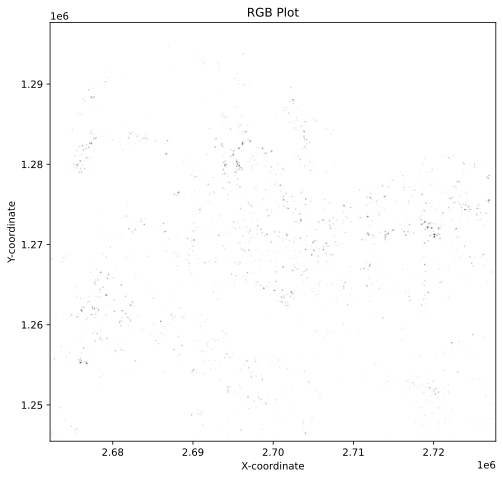

In [9]:
tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TMT_p4.tif')

with rasterio.open(tif_path) as src:
    # Read the RGB bands
    red_band = src.read(4)
    green_band = src.read(3)
    blue_band = src.read(2)

    # Clip values to be between 0 and 10000
    red_band = red_band.clip(0, 10000)
    green_band = green_band.clip(0, 10000)
    blue_band = blue_band.clip(0, 10000)

    # Normalize values to [0, 1]
    red_band_normalized = red_band / 10000.0
    green_band_normalized = green_band / 10000.0
    blue_band_normalized = blue_band / 10000.0
    
    # Create RGB natural color composite
    rgb = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))
    # Replace NaN values with white
    rgb = np.where(np.isnan(rgb), 1.0, rgb)

    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, extent=extent)
    plt.title('RGB Plot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

In [ ]:
# Crop to see soil

tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TLS_p43.tif')

with rasterio.open(tif_path) as src:
    # Read the RGB bands
    red_band = src.read(4)
    green_band = src.read(3)
    blue_band = src.read(2)

    # Clip values to be between 0 and 10000
    red_band = red_band.clip(0, 10000)
    green_band = green_band.clip(0, 10000)
    blue_band = blue_band.clip(0, 10000)

    # Normalize values to [0, 1]
    red_band_normalized = red_band / 10000.0
    green_band_normalized = green_band / 10000.0
    blue_band_normalized = blue_band / 10000.0
    
    # Create RGB natural color composite
    rgb = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))
    # Replace NaN values with white
    rgb = np.where(np.isnan(rgb), 1.0, rgb)

    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    print(extent)
    crop_extent = [2605880, 1143400, 2608000, 1147000]

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, extent=extent)
    plt.title('RGB Plot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.xlim(crop_extent[0], crop_extent[2])
    plt.ylim(crop_extent[1], crop_extent[3])
    plt.show()

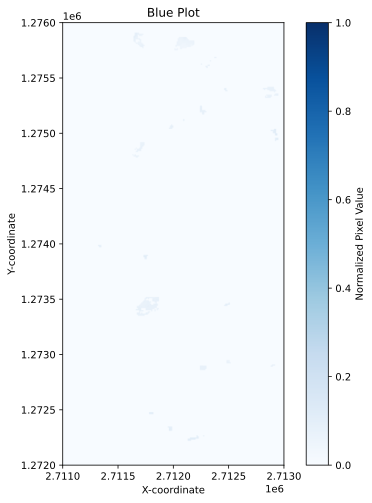

In [15]:
# See just the blue band: is it enough to see where snow?

tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TMT_p4.tif')

with rasterio.open(tif_path) as src:
    # Read the blue band
    blue_band = src.read(2)
    blue_band = blue_band.clip(0, 10000)
    blue_band_normalized = blue_band / 10000.0
    blue_band_normalized = np.where(np.isnan(blue_band_normalized), 0, blue_band_normalized)
    
    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crop_extent = [2711000, 1272000, 2713000, 1276000]

    plt.figure(figsize=(8, 8))
    plt.imshow(blue_band_normalized, cmap='Blues', extent=extent, norm=Normalize(vmin=0, vmax=1))
    plt.title('Blue Plot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(label='Normalized Pixel Value')
    plt.xlim(crop_extent[0], crop_extent[2])
    plt.ylim(crop_extent[1], crop_extent[3])
    plt.show()

In [ ]:
# Histplot of blue values

tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TLS_p43.tif')

with rasterio.open(tif_path) as src:
    # Read the blue band
    blue_band = src.read(2)
    blue_band = blue_band.clip(0, 10000)
    blue_band_normalized = blue_band / 10000.0
    blue_band_normalized = np.where(np.isnan(blue_band_normalized), 0, blue_band_normalized)

    # Flatten the 2D array to 1D for histogram plotting
    blue_values = blue_band_normalized.flatten()

    # Create a histogram
    plt.figure(figsize=(4, 3))
    plt.hist(blue_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Histogram of Blue Band Values')
    plt.xlabel('Normalized Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Count portion of blue vals > 0.2
    mask = blue_band_normalized > 0.2
    count_greater_than_02 = np.sum(mask)
    portion_greater_than_02 = count_greater_than_02 / blue_band.size
    print(f"Portion of blue values greater than 0.2: {portion_greater_than_02:.2%}")
    

In [ ]:
# See just the red band

tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TLS_p43.tif')

with rasterio.open(tif_path) as src:
    # Read the blue band
    red_band = src.read(4)
    red_band = red_band.clip(0, 10000)
    red_band_normalized = red_band / 10000.0
    red_band_normalized = np.where(np.isnan(red_band_normalized), 0, red_band_normalized)
    
    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    plt.figure(figsize=(8, 8))
    plt.imshow(red_band_normalized, cmap='Reds', extent=extent, norm=Normalize(vmin=0, vmax=1))
    plt.title('Red Plot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(label='Normalized Pixel Value')
    plt.show()

In [ ]:
# See just the red band

tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TLS_p43.tif')

with rasterio.open(tif_path) as src:
    # Read the blue band
    green_band = src.read(4)
    green_band = green_band.clip(0, 10000)
    green_band_normalized = green_band / 10000.0
    green_band_normalized = np.where(np.isnan(green_band_normalized), 0, green_band_normalized)
    
    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    plt.figure(figsize=(8, 8))
    plt.imshow(red_band_normalized, cmap='Greens', extent=extent, norm=Normalize(vmin=0, vmax=1))
    plt.title('Red Plot')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(label='Normalized Pixel Value')
    plt.show()

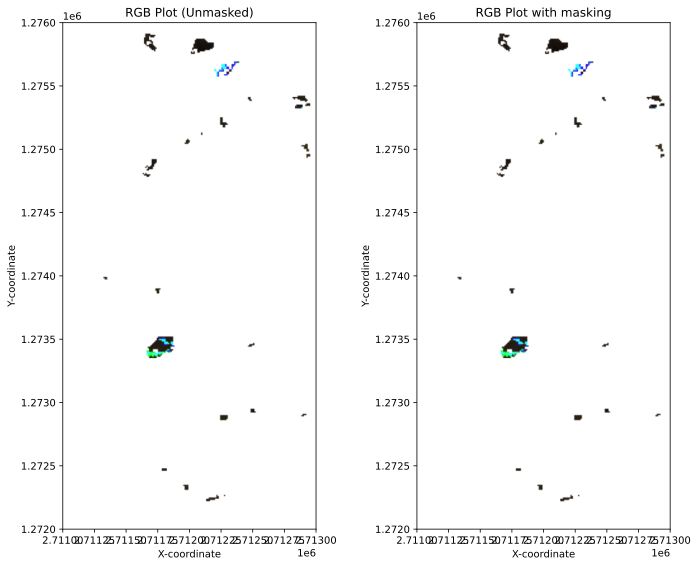

In [25]:
# Plot after masking out high blue values


tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TMT_p4.tif')

with rasterio.open(tif_path) as src:
    # Read the RGB bands
    red_band = src.read(4)
    green_band = src.read(3)
    blue_band = src.read(2)

    # Clip values to be between 0 and 10000
    red_band = red_band.clip(0, 10000)
    green_band = green_band.clip(0, 10000)
    blue_band = blue_band.clip(0, 10000)

    # Normalize values to [0, 1]
    red_band_normalized = red_band / 10000.0
    green_band_normalized = green_band / 10000.0
    blue_band_normalized = blue_band / 10000.0

    # Create RGB natural color composite
    rgb = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))
    # Replace NaN values with white
    rgb = np.where(np.isnan(rgb), 1.0, rgb)

    # Create a boolean mask for high red and blue
    mask_blue = blue_band_normalized > 0.2
    mask_red = red_band_normalized > 0.3
    mask_green = green_band_normalized > 0.3
    rgb_masked = np.copy(rgb)
    rgb_masked[mask_blue] = [1, 1, 1]
    rgb_masked[mask_red] = [1, 1, 1]
    rgb_masked[mask_green] = [1, 1, 1]

    # Define the bounding box for cropping (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crop_extent = [2711000, 1272000, 2713000, 1276000]


    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))

    # Plot unmasked RGB
    axes[0].imshow(rgb, extent=extent)
    axes[0].set_title('RGB Plot (Unmasked)')
    axes[0].set_xlabel('X-coordinate')
    axes[0].set_ylabel('Y-coordinate')
    axes[0].set_xlim(crop_extent[0], crop_extent[2])
    axes[0].set_ylim(crop_extent[1], crop_extent[3])

    # Plot masked RGB
    axes[1].imshow(rgb_masked, extent=extent)
    axes[1].set_title('RGB Plot with masking')
    axes[1].set_xlabel('X-coordinate')
    axes[1].set_ylabel('Y-coordinate')
    axes[1].set_xlim(crop_extent[0], crop_extent[2])
    axes[1].set_ylim(crop_extent[1], crop_extent[3])


    plt.tight_layout()
    plt.show()

In [ ]:
# Plot multiple rasters for a year

raster_paths = ['S2_BS_2017_31TGN_p4.tif', 'S2_BS_2017_31TGM_p2.tif', 'S2_BS_2017_32TLT_p2.tif', 'S2_BS_2017_32TLT_p4.tif', 'S2_BS_2017_32TMT_p3.tif', 'S2_BS_2017_32TNT_p2.tif']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axs = axs.flatten()

for i, tif_path in enumerate(raster_paths):
    tif_path_full = base_dir.joinpath(f'data/S2_baresoil_GEE/{tif_path}')

    with rasterio.open(tif_path_full) as src:
        # Read the RGB bands
        red_band = src.read(4)
        green_band = src.read(3)
        blue_band = src.read(2)

        # Clip values to be between 0 and 10000
        red_band = red_band.clip(0, 10000)
        green_band = green_band.clip(0, 10000)
        blue_band = blue_band.clip(0, 10000)

        # Normalize values to [0, 1]
        red_band_normalized = red_band / 10000.0
        green_band_normalized = green_band / 10000.0
        blue_band_normalized = blue_band / 10000.0

        # Create RGB natural color composite
        rgb = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))
        # Replace NaN values with white
        rgb = np.where(np.isnan(rgb), 1.0, rgb)

        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        axs[i].imshow(rgb, extent=extent)
        axs[i].set_title(f'{tif_path}')
        axs[i].set_xlabel('X-coordinate')
        axs[i].set_ylabel('Y-coordinate')

# Raster to gdf

In [26]:
def load_raster_gdf(tif_path: Path):
    """Load raster data into a GeoDataFrame.
    
    :param tif_path: Path to the GeoTIFF raster file
    """

    # Read the raster data using rasterio
    with rasterio.open(tif_path) as src:
        # Read raster data as a NumPy array
        raster_array = src.read()  # Read all bands

        # Get the metadata for coordinate reference system (CRS) and transform
        crs = src.crs.to_string()

    # Create a grid of points representing each pixel
    rows, cols = raster_array.shape[1:]
    x_coords, y_coords = np.meshgrid(np.linspace(src.bounds.left, src.bounds.right, cols),
                                    np.linspace(src.bounds.top, src.bounds.bottom, rows))

    # Flatten the coordinates
    flat_x_coords = x_coords.flatten()
    flat_y_coords = y_coords.flatten()

    # Create a GeoDataFrame with points
    geometry = [Point(x, y) for x, y in zip(flat_x_coords, flat_y_coords)]
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)

    # Add columns for each band value
    col_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'ndvi', 'nbr2']
    for i in range(len(col_names)):  
        band_values = raster_array[i]
        gdf[col_names[i]] = band_values.flatten()
   
    #gdf.dropna(inplace=True)
    gdf.dropna(how='all', inplace=True)

    return gdf

In [27]:
tif_path = base_dir.joinpath('data/S2_baresoil_GEE/S2_BS_2017_32TMT_p4.tif')
gdf = load_raster_gdf(tif_path)

In [66]:
# Identify where there are artifacts (the pixels that look blue in RGB plots) 
# -> what values do the bands have and what thresholds could be used in the rgb domain to drop them

# Crop the GeoDataFrame
minx, miny, maxx, maxy = [2712300, 1275000, 2712600, 1276000]
cropped_gdf = gdf.cx[minx:maxx, miny:maxy]
#cropped_gdf.dropna(inplace=True)

<Axes: >

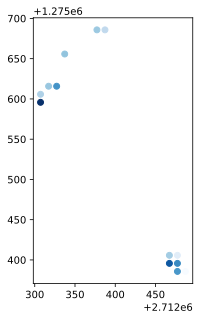

In [67]:
cropped_gdf.plot(column='B02', cmap='Blues')

In [72]:
cropped_gdf.dropna(subset=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'ndvi', 'nbr2'], how='all').head(2)

geometry  B01  B02     B03     B04     B05  \
12210548  POINT (2712357.230 1275685.789)  NaN  NaN  1212.0  1576.0  1821.0   
12210549  POINT (2712367.231 1275685.789)  NaN  NaN  1202.0  1572.0  1821.0   

             B06     B07     B08     B8A     B09     B11     B12      ndvi  \
12210548  1861.0  1937.0  1935.0  2108.0  2024.0  2947.0  2547.0  0.102250   
12210549  1861.0  1937.0  1958.0  2108.0  2024.0  2947.0  2547.0  0.109348   

              nbr2  
12210548  0.072807  
12210549  0.072807

# Plot sampled pixels

### For a single tile

In [2]:
tiles = {'32TMT': [(7.66286529045287, 47.845914826827),(7.68758850048273, 46.8581759574933),(9.12805716115049, 46.8656282472998),(9.1304703619161, 47.8536277114283),(7.66286529045287, 47.845914826827)],
            '32TLT': [(6.32792675947954,47.8225951267953),(6.37728036218156, 46.8356437136561),(7.81664846692137, 46.8595830833696),(7.79435498889756, 47.8473711518664),(6.32792675947954, 47.8225951267953)],
            '32TNT': [(8.9997326423426, 47.8537018420053),(8.99973758744939,46.8656998728757),(10.4401498244026, 46.8566398814282),(10.4672773767603, 47.8443250460311),(8.9997326423426, 47.8537018420053)],
            #'32TNS': [(8.99973715756222,46.9537091787344),(8.9997418700468, 45.9655511480415),(10.4166561015996, 45.9567698586004),(10.442508097938, 46.9446214409232),(8.99973715756222, 46.9537091787344)],
            #'32TMS': [(7.68543924709582, 46.9461622205863),(7.7089998702566, 45.9582586884214),(9.12596726307512, 45.9654817261501),(9.12826694512377, 46.9536373337673),(7.68543924709582, 46.9461622205863)],
            #'32TLS': [(6.37298980762373, 46.9235610080068),(6.42002507864337, 45.9364192287437),(7.83595551698163, 45.9596225320207),(7.81471043979331, 46.94757365544),(6.37298980762373, 46.9235610080068)],
            '31TGM': [(5.62648535526562, 46.9235730577955),(5.57945945554239, 45.9364308725672),(6.99300216652316, 45.8957352511058),(7.06565713267192, 46.8814596607493),(5.62648535526562, 46.9235730577955)],
            '31TGN': [(5.67153942638492, 47.8226075594756),(5.62219565549863, 46.8356557266896),(7.05902986502132, 46.793670687313),(7.13525847525188, 47.7791570713891),(5.67153942638492, 47.8226075594756)]}

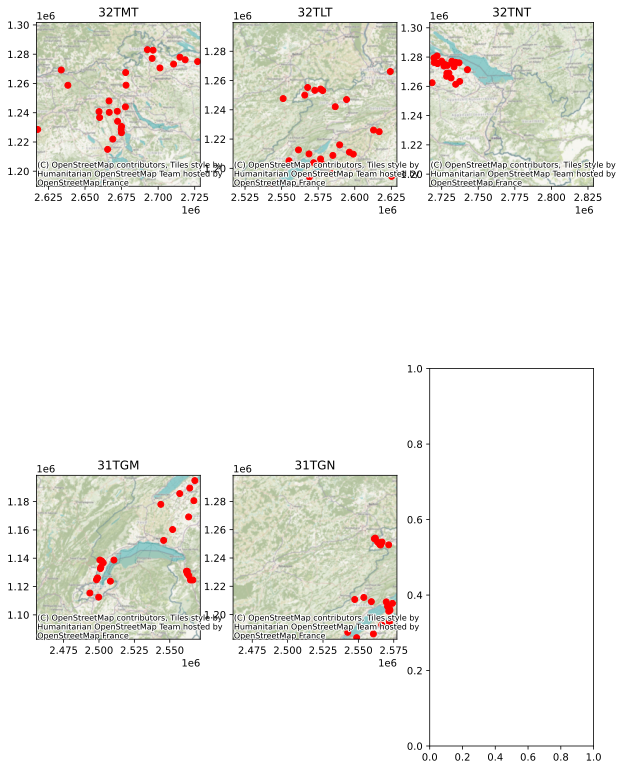

In [3]:
# See sampled pixels per tile

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,15))
axs = axs.flatten()

for i, tile_id in enumerate(tiles):

  pixels_path = base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_pixels_{tile_id}.pkl')
  pixs_df = pd.read_pickle(pixels_path)
  pixs_gdf = gpd.GeoDataFrame(pixs_df, geometry=pixs_df.geometry, crs='EPSG:2056')

  tile_gdf = gpd.GeoDataFrame(geometry=[Polygon(tiles[tile_id])], crs='EPSG:4326')
  bounds = tile_gdf.to_crs(pixs_gdf.crs).total_bounds

  pixs_gdf.plot(ax=axs[i], color='r')
  axs[i].set_xlim(bounds[0], bounds[2])
  axs[i].set_ylim(bounds[1], bounds[3])
  axs[i].set_title(f'{tile_id}')
  cx.add_basemap(axs[i], crs=pixs_gdf.crs)

In [3]:
spectra_path = base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_spectra_all_CH.pkl')
spectra = pd.read_pickle(spectra_path)

In [5]:
spectra

400     401     402     403     404     405     406     407     408   \
0   0.0691  0.0691  0.0691  0.0691  0.0691  0.0691  0.0691  0.0691  0.0691   
1   0.0620  0.0620  0.0620  0.0620  0.0620  0.0620  0.0620  0.0620  0.0620   
2   0.0605  0.0605  0.0605  0.0605  0.0605  0.0605  0.0605  0.0605  0.0605   
3   0.0706  0.0706  0.0706  0.0706  0.0706  0.0706  0.0706  0.0706  0.0706   
4   0.0676  0.0676  0.0676  0.0676  0.0676  0.0676  0.0676  0.0676  0.0676   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
20  0.0704  0.0704  0.0704  0.0704  0.0704  0.0704  0.0704  0.0704  0.0704   
21  0.0528  0.0528  0.0528  0.0528  0.0528  0.0528  0.0528  0.0528  0.0528   
22  0.0543  0.0543  0.0543  0.0543  0.0543  0.0543  0.0543  0.0543  0.0543   
23  0.0697  0.0697  0.0697  0.0697  0.0697  0.0697  0.0697  0.0697  0.0697   
24  0.0679  0.0679  0.0679  0.0679  0.0679  0.0679  0.0679  0.0679  0.0679   

      409   ...      2491      2492      2493      2494      2495      2496  \
0   0.0691  ...  0.232583  0.232291  0.231999  0.231707  0.231414  0.231120   
1   0.0620  ...  0.218311  0.218044  0.217776  0.217508  0.217239  0.216971   
2   0.0605  ...  0.213641  0.213380  0.213118  0.212856  0.212594  0.212331   
3   0.0706  ...  0.217763  0.217540  0.217317  0.217094  0.216871  0.216647   
4   0.0676  ...  0.219562  0.219305  0.219049  0.218792  0.218534  0.218276   
..     ...  ...       ...       ...       ...       ...       ...       ...   
20  0.0704  ...  0.232003  0.231701  0.231398  0.231095  0.230791  0.230487   
21  0.0528  ...  0.258116  0.257907  0.257699  0.257489  0.257280  0.257070   
22  0.0543  ...  0.250570  0.250372  0.250175  0.249977  0.249779  0.249580   
23  0.0697  ...  0.217094  0.216847  0.216599  0.216351  0.216103  0.215854   
24  0.0679  ...  0.243126  0.242902  0.242678  0.242453  0.242229  0.242003   

        2497      2498      2499      2500  
0   0.230826  0.230531  0.230236  0.229940  
1   0.216701  0.216431  0.216161  0.215890  
2   0.212068  0.211804  0.211540  0.211276  
3   0.216423  0.216199  0.215975  0.215750  
4   0.218018  0.217759  0.217500  0.217241  
..       ...       ...       ...       ...  
20  0.230182  0.229877  0.229572  0.229266  
21  0.256859  0.256648  0.256437  0.256225  
22  0.249381  0.249181  0.248981  0.248780  
23  0.215605  0.215356  0.215106  0.214856  
24  0.241777  0.241551  0.241324  0.241097  

[125 rows x 2101 columns]

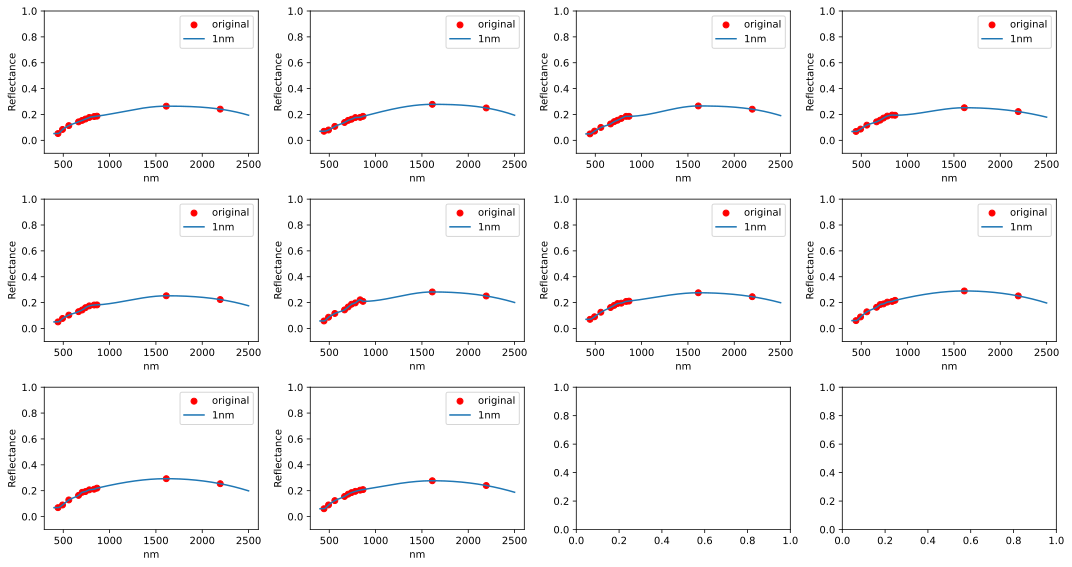

In [7]:
# For one tile see samples and interpolation

tile_id = '32TNT'
tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']
tile_index = tiles.index(tile_id)
#tile_index = 0 
cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

s2 = [443, 492, 560, 665, 704, 740, 781, 833, 864, 1612, 2194]
new_wavelengths = np.arange(400, 2501, 1)

pixels_path = base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_pixels_{tile_id}.pkl')
pixs_df = pd.read_pickle(pixels_path)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,8))
axs = axs.flatten()

for i, r in pixs_df.head(10).iterrows():
  axs[i].scatter(s2, r[cols], label='original', color='r')
  axs[i].plot(new_wavelengths, spectra.loc[i].iloc[tile_index], label=f'1nm')
  #print(i+tile_index)
  #axs[i].plot(new_wavelengths, spectra.iloc[i+tile_index], label=f'1nm')
  axs[i].legend()
  axs[i].set_ylim((-0.1,1))
  axs[i].set_ylabel('Reflectance')
  axs[i].set_xlabel('nm')
tile_index += len(pixs_df)

plt.tight_layout()
plt.show()

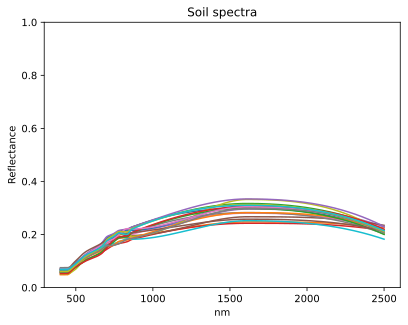

In [8]:
# See all the soil spectra that were sampled from a tile

tile_id = '32TMT'
tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']
tile_index = tiles.index(tile_id)

spectra_tile = spectra.groupby(spectra.index).apply(lambda x: x.iloc[tile_index]).reset_index(drop=True)

spectra_tile.sample(20).T.plot(legend=None)
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.ylabel('Reflectance')
plt.xlabel('nm')
plt.show()

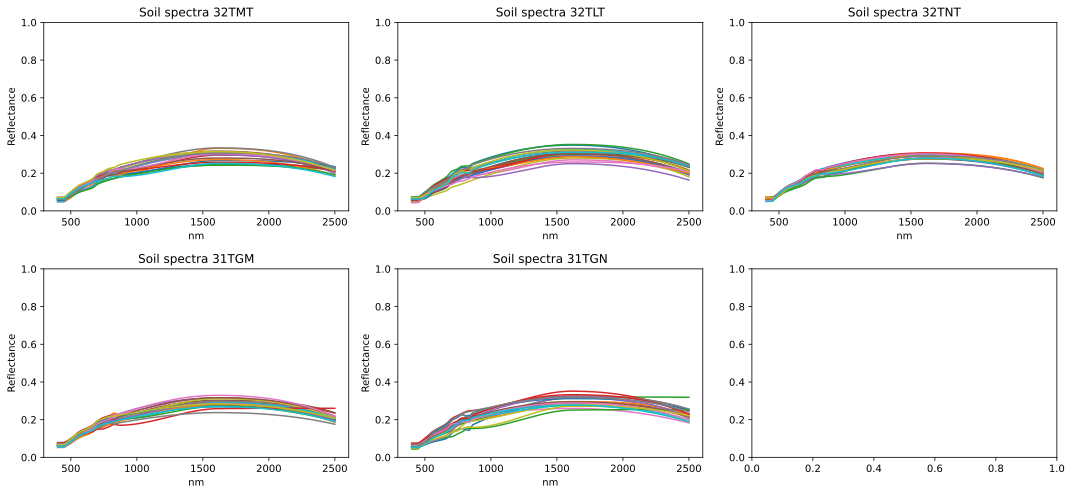

In [10]:
# Compare all tiles

tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
axs = axs.flatten()

for i, tile_id in enumerate(tiles):

  spectra_tile = spectra.groupby(spectra.index).apply(lambda x: x.iloc[i]).reset_index(drop=True)

  spectra_tile.sample(20).T.plot(ax=axs[i],legend=None)
  axs[i].set_xlabel('nm')
  axs[i].set_ylabel('Reflectance')
  axs[i].set_title(f'Soil spectra {tile_id}')
  axs[i].set_ylim((0,1))
  axs[i].set_ylabel('Reflectance')
  axs[i].set_xlabel('nm')

plt.tight_layout()
plt.show()



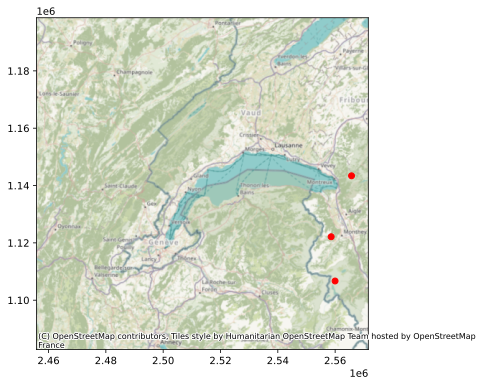

In [86]:
# Check strange jumps in 31TGM

tiles = {'32TMT': [(7.66286529045287, 47.845914826827),(7.68758850048273, 46.8581759574933),(9.12805716115049, 46.8656282472998),(9.1304703619161, 47.8536277114283),(7.66286529045287, 47.845914826827)],
            '32TLT': [(6.32792675947954,47.8225951267953),(6.37728036218156, 46.8356437136561),(7.81664846692137, 46.8595830833696),(7.79435498889756, 47.8473711518664),(6.32792675947954, 47.8225951267953)],
            '32TNT': [(8.9997326423426, 47.8537018420053),(8.99973758744939,46.8656998728757),(10.4401498244026, 46.8566398814282),(10.4672773767603, 47.8443250460311),(8.9997326423426, 47.8537018420053)],
            '32TNS': [(8.99973715756222,46.9537091787344),(8.9997418700468, 45.9655511480415),(10.4166561015996, 45.9567698586004),(10.442508097938, 46.9446214409232),(8.99973715756222, 46.9537091787344)],
            '32TMS': [(7.68543924709582, 46.9461622205863),(7.7089998702566, 45.9582586884214),(9.12596726307512, 45.9654817261501),(9.12826694512377, 46.9536373337673),(7.68543924709582, 46.9461622205863)],
            '32TLS': [(6.37298980762373, 46.9235610080068),(6.42002507864337, 45.9364192287437),(7.83595551698163, 45.9596225320207),(7.81471043979331, 46.94757365544),(6.37298980762373, 46.9235610080068)],
            '31TGM': [(5.62648535526562, 46.9235730577955),(5.57945945554239, 45.9364308725672),(6.99300216652316, 45.8957352511058),(7.06565713267192, 46.8814596607493),(5.62648535526562, 46.9235730577955)],
            '31TGN': [(5.67153942638492, 47.8226075594756),(5.62219565549863, 46.8356557266896),(7.05902986502132, 46.793670687313),(7.13525847525188, 47.7791570713891),(5.67153942638492, 47.8226075594756)]}
tile_id = '31TGM'
pixels_path = base_dir.joinpath(f'results/GEE_baresoil/sampled_pixels_{tile_id}.pkl')
pixs_df = pd.read_pickle(pixels_path)
pixs_gdf = gpd.GeoDataFrame(pixs_df, geometry=pixs_df.geometry, crs='EPSG:2056')

tile_gdf = gpd.GeoDataFrame(geometry=[Polygon(tiles[tile_id])], crs='EPSG:4326')
bounds = tile_gdf.to_crs(pixs_gdf.crs).total_bounds

fig, ax = plt.subplots(figsize=(8,6))
pixs_gdf [pixs_gdf .B01 > 0.2].plot(ax=ax, color='r')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, crs=pixs_gdf.crs)

### See for all of CH

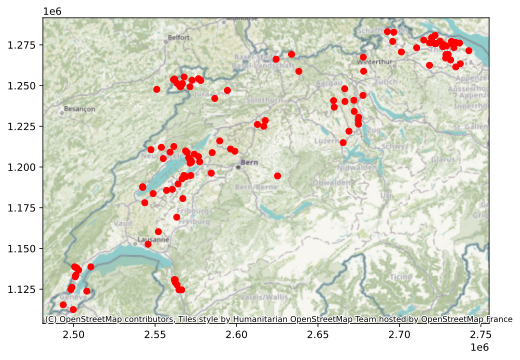

In [12]:
tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']

pixs_df = [pd.read_pickle(file) for tile_id in tiles for file in glob.glob(str(base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_pixels_{tile_id}.pkl')))]
pixs_df = pd.concat(pixs_df, ignore_index=True)
pixs_gdf= gpd.GeoDataFrame(pixs_df, geometry=pixs_df.geometry, crs='EPSG:2056')

fig, ax = plt.subplots(figsize=(8,6))
pixs_gdf.plot(ax=ax, color='r')
cx.add_basemap(ax, crs=pixs_gdf.crs)

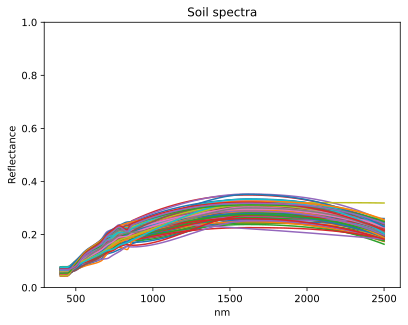

In [14]:
# See all the soil spectra that were sampled
spectra.T.plot(legend=None)#sample(30).
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.ylabel('Reflectance')
plt.xlabel('nm')
plt.show()


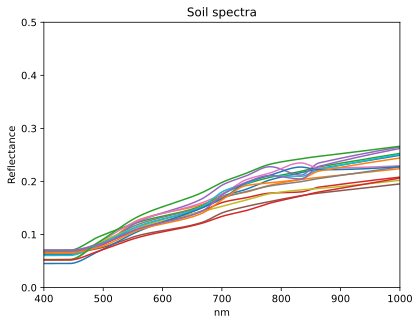

In [22]:
# See all the soil spectra that were sampled
spectra.sample(15).T.plot(legend=None)
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,0.5))
plt.ylabel('Reflectance')
plt.xlabel('nm')
plt.xlim((400, 1000))
plt.show()

### 